In [96]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm

from gymnasium.wrappers.time_limit import TimeLimit

from dice_rl_TU_Vienna.value import get_get_policy_value_env
from dice_rl_TU_Vienna.dataset import load_or_create_dataset_Experience
from dice_rl_TU_Vienna.environment import test_env

from dice_rl_TU_Vienna.estimators.get import get_pv_s_OnPE, get_pv_s_OffPE, get_sdc_s, get_vaf_s
from dice_rl_TU_Vienna.estimators.tabular.aux_estimates.io import load_or_create_aux_estimates
from dice_rl_TU_Vienna.estimators.tabular.tabular_vafe          import TabularVafe
from dice_rl_TU_Vienna.estimators.tabular.tabular_dice          import TabularDice
from dice_rl_TU_Vienna.estimators.tabular.tabular_dual_dice     import TabularDualDice
from dice_rl_TU_Vienna.estimators.tabular.tabular_gradient_dice import TabularGradientDice

from plugins.boyan_chain.environment import get_env
from plugins.boyan_chain.policy import TFPolicyBoyanChain
from plugins.boyan_chain.analytical_solver import AnalyticalSolverBoyanChain
from plugins.boyan_chain.tabular.config import *

from utils.general import safe_zip, iterate_print
from utils.bedtime import computer_sleep

In [22]:
computer_sleep()

                                          Sleeping now...


# Prepare

In [98]:
get_policy_value = { seed: { N: {} for N in Ns } for seed in seeds }
rewards          = { seed: { N: {} for N in Ns } for seed in seeds }

for seed in iterate_print(seeds, "seed"):
    for N in tqdm(Ns):

        env_e = TimeLimit( get_env(seed, N, kind["e"]), max_episode_steps=N)
        env_c = TimeLimit( get_env(seed, N, kind["c"]), max_episode_steps=N)

        x, y = get_get_policy_value_env(
            env=env_e,
            get_act=get_act,
            num_trajectory=1_000,
            verbosity=0,
        )
        x.__name__ = "OnPE evaluation"

        get_policy_value[seed][N]["e"] = x
        rewards         [seed][N]["e"] = x

        x, y = get_get_policy_value_env(
            env=env_c,
            get_act=get_act,
            num_trajectory=1_000,
            verbosity=0,
        )
        x.__name__ = "OnPE evaluation"

        get_policy_value[seed][N]["c"] = x
        rewards         [seed][N]["c"] = y

seed=0


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


seed=1


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


seed=2


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


seed=3


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


In [99]:
hparam_str_dataset = {
    seed: {
        N: {
            k: f"{seed=}_{num_experience=}_{N=}_kind={kind[k]}"
                for k in K
        }
            for N in Ns
    }
        for seed in seeds
}

In [100]:
dataset_dir = {
    seed: {
        N: {
            k: os.path.join(datasets_dir, hparam_str_dataset[seed][N][k])
                for k in K                
        }
            for N in Ns
    }
        for seed in seeds
}

In [101]:
dataset = {
    seed: {
        N: {
            k: load_or_create_dataset_Experience(
                dataset_dir=dataset_dir[seed][N][k],
                env=get_env(seed, N, kind[k]),
                num_experience=num_experience, seed=seed,
                verbosity=1,
            )
                for k in iterate_print(K, "k")
        }
            for N in iterate_print(Ns, "N")
    }
        for seed in iterate_print(seeds, "seed")
}

seed=0
N=2
k=e
Try loading dataset data/boyan_chain/datasets/seed=0_num_experience=100000_N=2_kind=episodic/dataset-ctr.pkl
data/boyan_chain/datasets/seed=0_num_experience=100000_N=2_kind=episodic/dataset-ctr.pkl
k=c
Try loading dataset data/boyan_chain/datasets/seed=0_num_experience=100000_N=2_kind=continuing/dataset-ctr.pkl
data/boyan_chain/datasets/seed=0_num_experience=100000_N=2_kind=continuing/dataset-ctr.pkl
N=4
k=e
Try loading dataset data/boyan_chain/datasets/seed=0_num_experience=100000_N=4_kind=episodic/dataset-ctr.pkl
data/boyan_chain/datasets/seed=0_num_experience=100000_N=4_kind=episodic/dataset-ctr.pkl
k=c
Try loading dataset data/boyan_chain/datasets/seed=0_num_experience=100000_N=4_kind=continuing/dataset-ctr.pkl
data/boyan_chain/datasets/seed=0_num_experience=100000_N=4_kind=continuing/dataset-ctr.pkl
N=8
k=e
Try loading dataset data/boyan_chain/datasets/seed=0_num_experience=100000_N=8_kind=episodic/dataset-ctr.pkl
data/boyan_chain/datasets/seed=0_num_experience=1000

In [102]:
hparam_str_policy = {
    N: f"{p=}_{N=}"
        for N in Ns
}

In [103]:
target_policy = {
    N: TFPolicyBoyanChain(N=N, p=p, tabular_continuous=tabular_continuous)
        for N in Ns
}

In [104]:
aux_estimates_dir = {
    seed: {
        N: {
            k: os.path.join(save_dir, hparam_str_policy[N], hparam_str_dataset[seed][N][k])
                for k in K
        }
            for N in Ns
    }
        for seed in seeds
}

In [105]:
aux_estimates = {
    seed: {
        N: {
            k: load_or_create_aux_estimates(
                aux_estimates_dir=aux_estimates_dir[seed][N][k],
                dataset=dataset[seed][N][k],
                target_policy=target_policy[N],
                by="experience",
                verbosity=0,
            )
                for k in iterate_print(K, "k")
        }
            for N in iterate_print(Ns, "N")
    }
        for seed in iterate_print(seeds, "seed")
}

seed=0
N=2
k=e
k=c
N=4
k=e
k=c
N=8
k=e
k=c
N=16
k=e
k=c
N=32
k=e
k=c
N=64
k=e
k=c
N=128
k=e
k=c
N=256
k=e
k=c
N=512
k=e
k=c
N=1024
k=e
k=c
seed=1
N=2
k=e
k=c
N=4
k=e
k=c
N=8
k=e
k=c
N=16
k=e
k=c
N=32
k=e
k=c
N=64
k=e
k=c
N=128
k=e
k=c
N=256
k=e
k=c
N=512
k=e
k=c
N=1024
k=e
k=c
seed=2
N=2
k=e
k=c
N=4
k=e
k=c
N=8
k=e
k=c
N=16
k=e
k=c
N=32
k=e
k=c
N=64
k=e
k=c
N=128
k=e
k=c
N=256
k=e
k=c
N=512
k=e
k=c
N=1024
k=e
k=c
seed=3
N=2
k=e
k=c
N=4
k=e
k=c
N=8
k=e
k=c
N=16
k=e
k=c
N=32
k=e
k=c
N=64
k=e
k=c
N=128
k=e
k=c
N=256
k=e
k=c
N=512
k=e
k=c
N=1024
k=e
k=c


# Episodic

## `get_pvs` & `get_sdcs`

In [106]:
# approximate

pvs_OnPE = { seed: { N: {} for N in Ns } for seed in seeds }

pvs_s_OffPE = { seed: { N: {} for N in Ns } for seed in seeds }
pvs_w_OffPE = { seed: { N: {} for N in Ns } for seed in seeds }

sdcs_DICE = { seed: { N: {} for N in Ns } for seed in seeds }

for seed in iterate_print(seeds, "seed"):
    for N in iterate_print(Ns, "N"):
        k = "e"

        estimator_OnPE = get_policy_value[seed][N][k]

        estimators_VAFE = [ TabularVafe(aux_estimates=aux_estimates[seed][N][k], num_obs=N+1, n_act=2), ]
        args = [ dataset[seed][N][k], target_policy[N], aux_estimates[seed][N][k], ]
        estimators_DICE = [ TabularDice(*args), TabularDualDice(*args), TabularGradientDice(*args), ]
        estimators_OffPE = estimators_VAFE + estimators_DICE

        dir = os.path.join(aux_estimates_dir[seed][N][k], "by=experience_obs_act=True")

        pvs_OnPE[seed][N][k] = get_pv_s_OnPE(
            estimator_s=estimator_OnPE,
            gamma_s=gammas,
            save_dir=dir,
            verbosity=0,
        )

        pvs_s_OffPE[seed][N][k] = get_pv_s_OffPE(
            estimator_s=estimators_OffPE,
            gamma_s=gammas,
            projected=projected,
            weighted=False,
            modified=modified,
            lam=lam,
            save_dir=dir,
            verbosity=0,
        )

        pvs_w_OffPE[seed][N][k] = get_pv_s_OffPE(
            estimator_s=estimators_OffPE,
            gamma_s=gammas,
            projected=projected,
            weighted=True,
            modified=modified,
            lam=lam,
            save_dir=dir,
            verbosity=0,
        )

        sdcs_DICE[seed][N][k] = get_sdc_s(
            estimator_s=estimators_DICE,
            gamma_s=gammas,
            projected=projected,
            modified=modified,
            lam=lam,
            save_dir=dir,
            verbosity=0,                
        )

pvs_OffPE = { False: pvs_s_OffPE, True: pvs_w_OffPE, }

seed=0
N=2
N=4
N=8
N=16
N=32
N=64
N=128
N=256
N=512
N=1024
seed=1
N=2
N=4
N=8
N=16
N=32
N=64
N=128
N=256
N=512
N=1024
seed=2
N=2
N=4
N=8
N=16
N=32
N=64
N=128
N=256
N=512
N=1024
seed=3
N=2
N=4
N=8
N=16
N=32
N=64
N=128
N=256
N=512
N=1024


In [107]:
# analytical

pvs_ANAL  = { N: { k: [] for k in K } for N in Ns }
sdcs_ANAL = { N: { k: [] for k in K } for N in Ns }

for N in iterate_print(Ns, "N"):
    k = "e"

    analytical_solver = AnalyticalSolverBoyanChain(
        N=N, p=p, kind=kind[k], )
    
    for gamma in gammas:
        pv, (_, sdc), _ = analytical_solver.solve(
            gamma=gamma, projected=projected, ) # type: ignore
        
        pvs_ANAL [N][k].append(pv)
        sdcs_ANAL[N][k].append(sdc)

N=2
N=4
N=8
N=16
N=32
N=64
N=128
N=256
N=512
N=1024


## Plot

In [108]:
labels_OnPE = ["OnPE evaluation"]
labels_VAFE = ["TabularVafe"]
labels_DICE = ["TabularDice", "TabularDualDice", "TabularGradientDice"]
labels_ANAL = ["analytical"]

colors_OnPE = ["grey"]
colors_VAFE = ["blue"]
colors_DICE = ["orange", "green", "red"]
colors_ANAL = ["black"]

markers_OnPE = ["^"]
markers_VAFE = ["1"]
markers_DICE = ["2", "3", "4"]
markers_ANAL = ["."]

labels_approx  = labels_OnPE  + labels_VAFE  + labels_DICE
colors_approx  = colors_OnPE  + colors_VAFE  + colors_DICE
markers_approx = markers_OnPE + markers_VAFE + markers_DICE

In [112]:
def plot_episodic(pv_sdc, errors=None, weighted=None):
    if pv_sdc == "pv":
        assert errors is not None
        assert weighted is not None

    k = "e"

    for i, gamma in enumerate(gammas):

        plt.figure()

        x = Ns

        if pv_sdc == "pv":
            if errors:
                labels  = labels_approx
                colors  = colors_approx
                markers = markers_approx
            else:
                labels  = labels_approx  + labels_ANAL
                colors  = colors_approx  + colors_ANAL
                markers = markers_approx + markers_ANAL

        if pv_sdc == "sdc":
            labels  = labels_DICE
            colors  = colors_DICE
            markers = markers_DICE

        Z = labels, colors, markers
        for j, z in enumerate(safe_zip(*Z)):
            label, color, marker = z

            if pv_sdc == "pv":

                def a(seed, N):
                    if label == "OnPE evaluation":
                        return pvs_OnPE[seed][N][k][i]
                    elif label == "analytical":
                        return pvs_ANAL[N][k][i]
                    else:
                        return pvs_OffPE[weighted][seed][N][k][j-1][i] # type: ignore

                b = lambda N: pvs_ANAL[N][k][i]

                if errors:
                    ys = np.array([
                        [ np.abs( a(seed, N) - b(N) ) for N in Ns ]
                            for seed in seeds
                    ])

                else:
                    ys = np.array([
                        [ a(seed, N) for N in Ns ]
                            for seed in seeds
                    ])

            if pv_sdc == "sdc":
                a = lambda seed, N: sdcs_DICE[seed][N][k][j][i]
                b = lambda N: sdcs_ANAL[N][k][i]

                ys = np.array([
                    [ np.mean( ( a(seed, N) - b(N) ) ** 2 ) for N in Ns ]
                        for seed in seeds
                ])

            y_mean = np.mean(ys, axis=0)
            y_std = np.std(ys, axis=0)

            y_down = y_mean - y_std * std_girth
            y_up   = y_mean + y_std * std_girth

            l = label
            if l == "TabularDice":         l += f", {modified=}"
            if l == "TabularGradientDice": l += f", {lam=}"

            plt.plot(x, y_mean, color=color, marker=marker, label=l)
            plt.fill_between(x, y_down, y_up, color=color, alpha=alpha)

        if pv_sdc == "pv":  do_yscale = errors
        if pv_sdc == "sdc": do_yscale = True

        plt.xscale("log")
        if do_yscale: plt.yscale("log")


        if pv_sdc == "pv":
            y = r"\hat{\rho}^\pi(\gamma)"
            z = r"\rho^\pi(\gamma)"
            if errors:
                ylabel = f"$ | {y} - {z} | $"
            else:
                ylabel = f"$ {z} $"

        if pv_sdc == "sdc":
            x = r"\mathbb{E}_D"
            y = r"\hat{w}_{\pi / D}(\gamma)"
            z = r"w_{\pi / D}(\gamma)"
            ylabel = f"$ {x} | {y} - {z} |^2 $"

        plt.xlabel("$N$")
        plt.ylabel(ylabel)

        if pv_sdc == "pv":
            if errors:
                measure = "PV Errors"
            else:
                measure = "PVs"

        if pv_sdc == "sdc":
            measure = "SDC MSEs"

        suptitle = f"{measure} - Boyan Chain Tabular - {kind[k]}"
        plt.suptitle(suptitle)

        if pv_sdc == "pv":  title = f"gamma={gammas[i]}, {projected=}, {weighted=}"
        if pv_sdc == "sdc": title = f"gamma={gammas[i]}, {projected=}"
        plt.title(title)

        plt.grid(linestyle=":")
        plt.legend()

        t = title.replace(", ", "_")
        file_name = f"{suptitle}; {t}.png"
        path = os.path.join(save_dir_images, file_name)
        plt.savefig(path)

        plt.show()

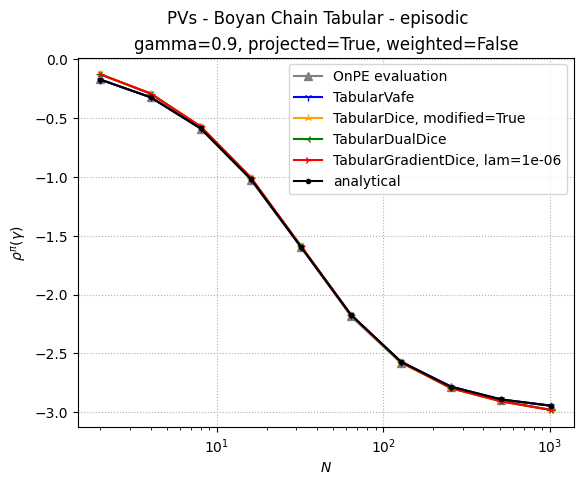

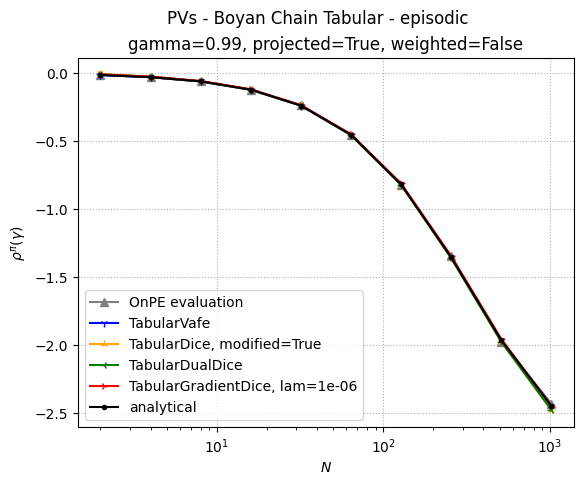

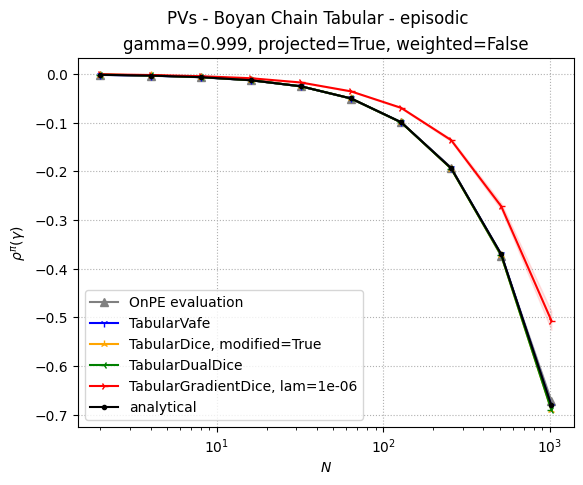

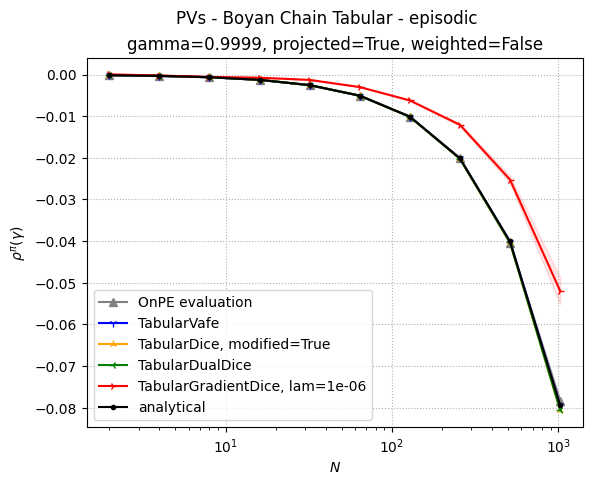

In [213]:
plot_episodic("pv", errors=False, weighted=False)

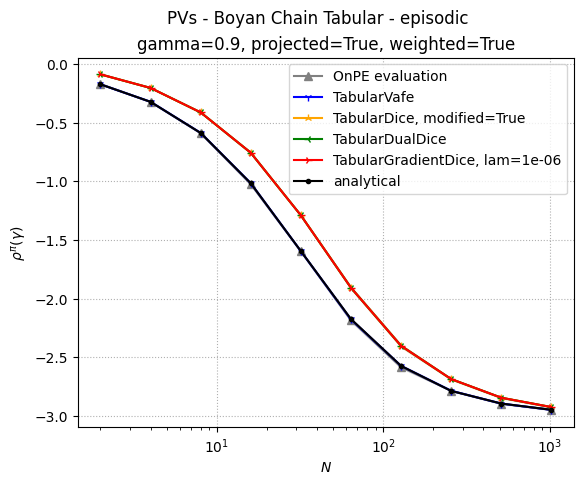

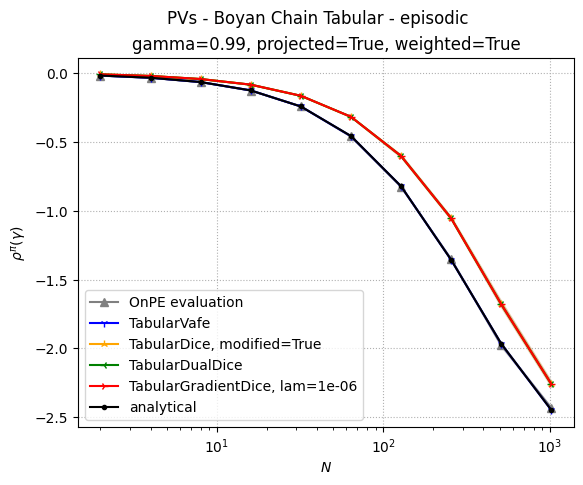

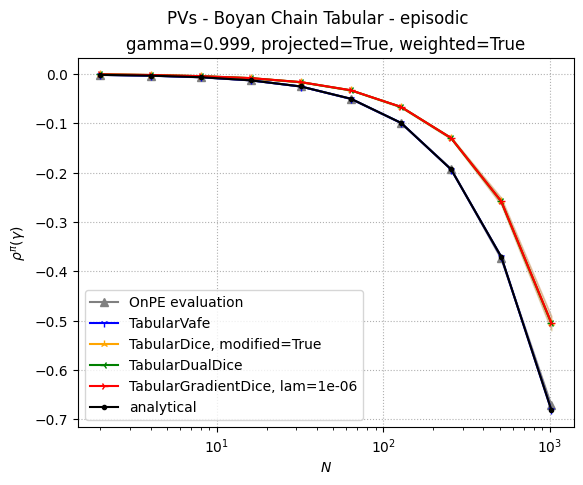

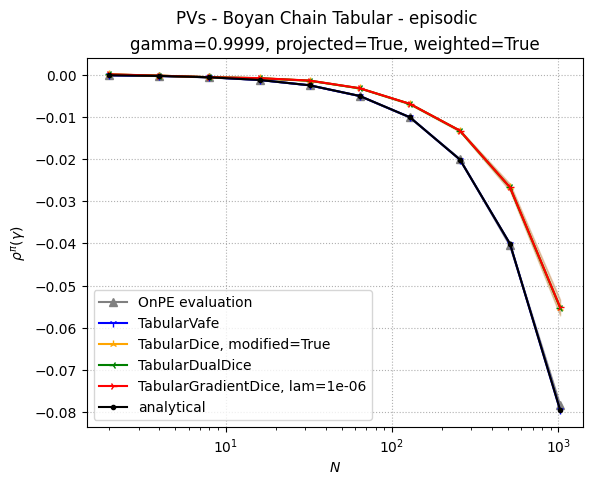

In [214]:
plot_episodic("pv", errors=False, weighted=True)

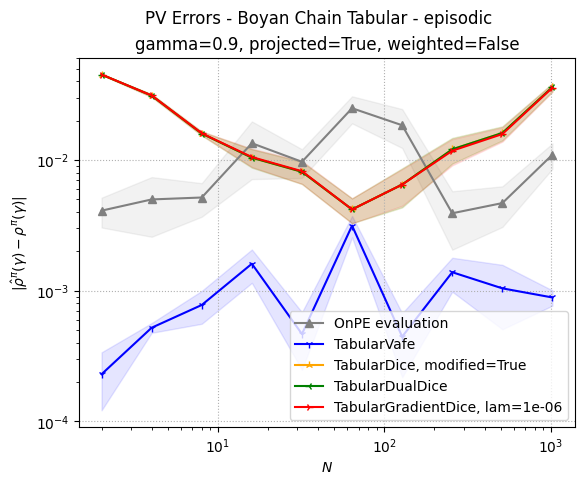

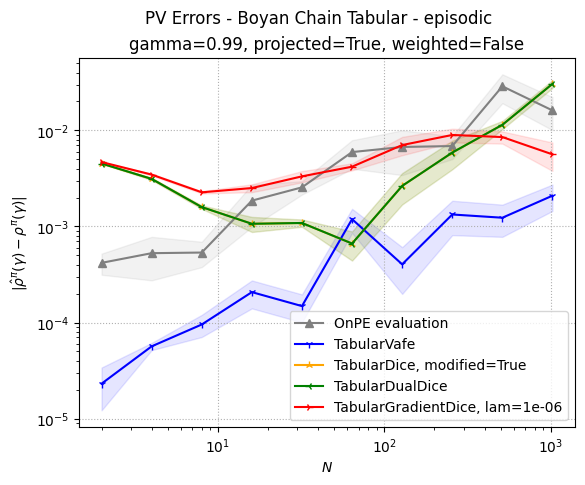

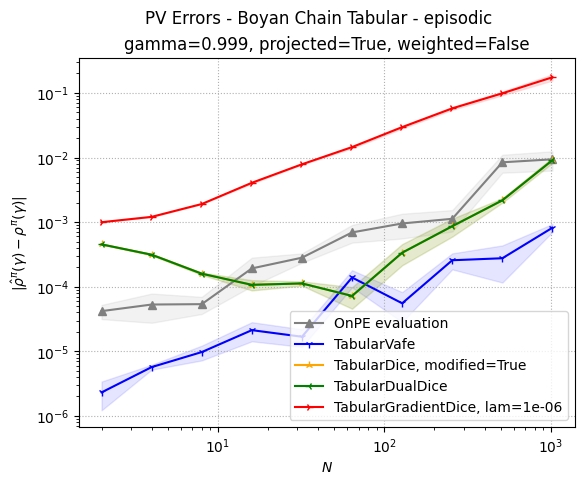

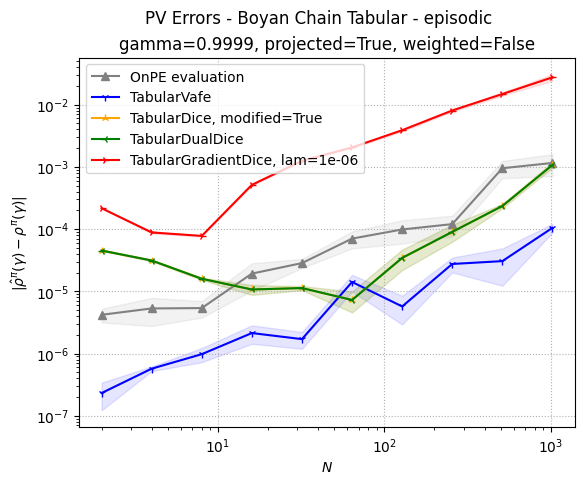

In [212]:
plot_episodic("pv", errors=True, weighted=False)

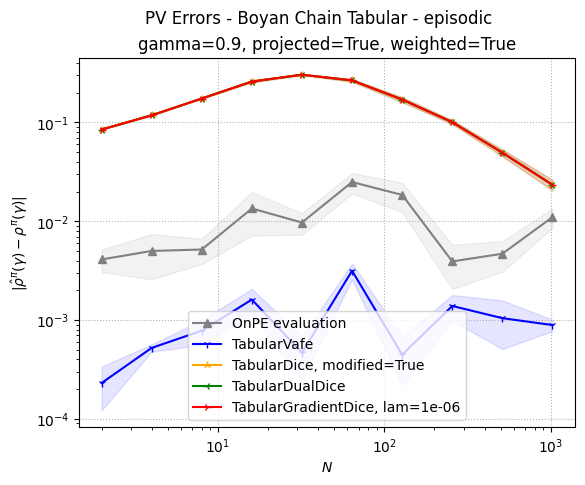

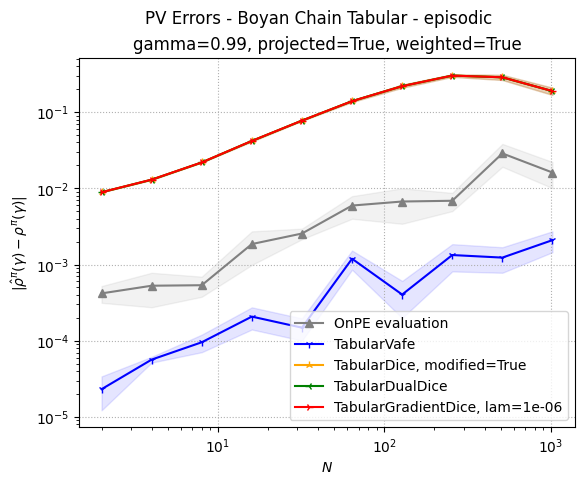

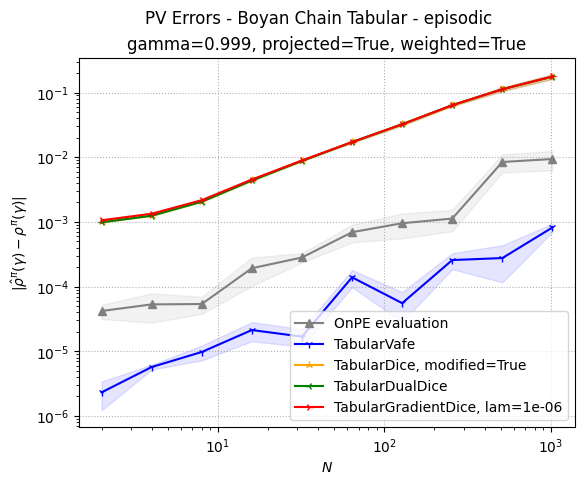

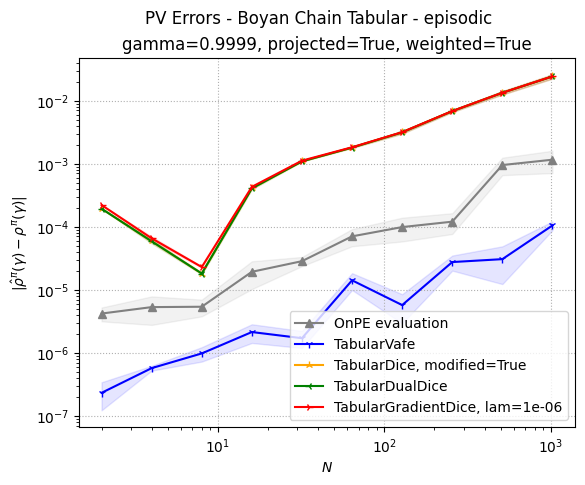

In [210]:
plot_episodic("pv", errors=True, weighted=True)

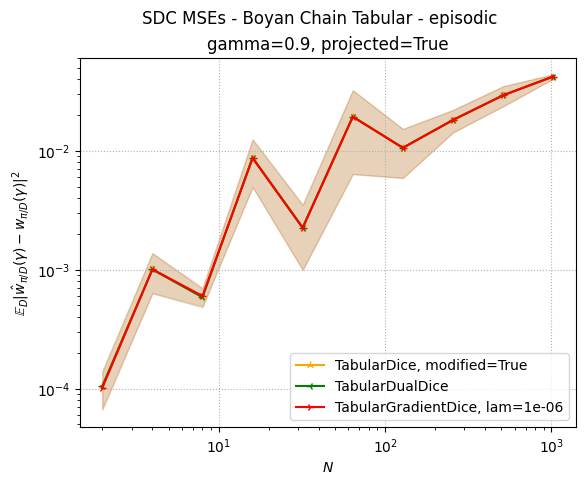

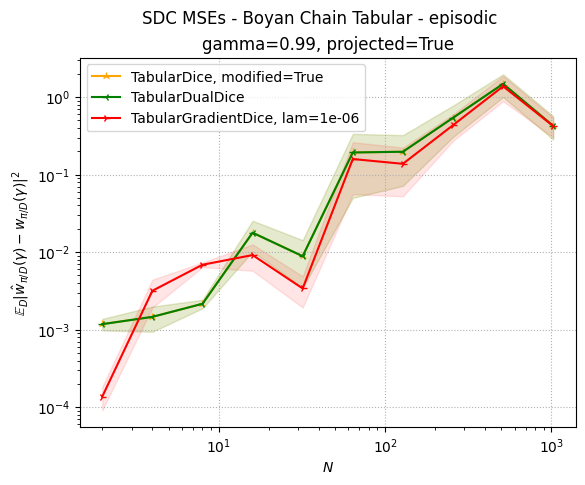

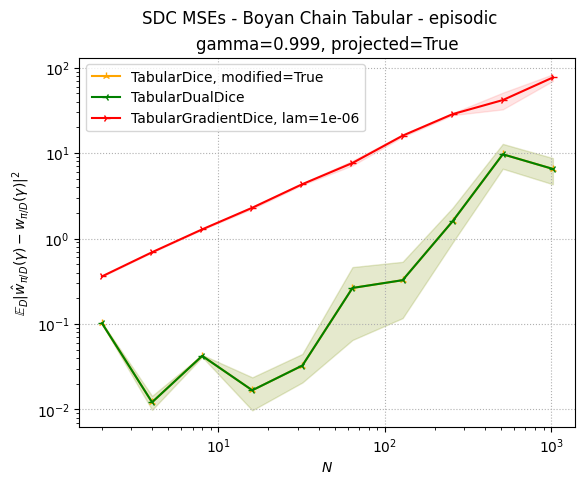

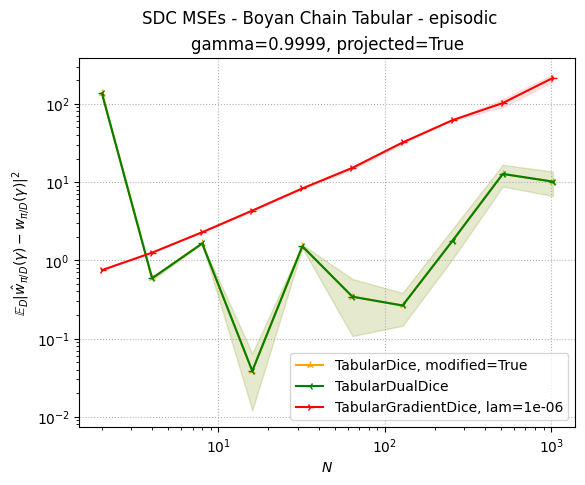

In [113]:
plot_episodic("sdc")

# Continuing

## `get_pvs` & `get_sdcs`

In [114]:
# approximate

pv_OnPE = { seed: { N: {} for N in Ns } for seed in seeds }
pv_s_DICE = { seed: { N: {} for N in Ns } for seed in seeds }
pv_w_DICE = { seed: { N: {} for N in Ns } for seed in seeds }

sdc_DICE = { seed: { N: {} for N in Ns } for seed in seeds }

for seed in iterate_print(seeds, "seed"):
    for N in iterate_print(Ns, "N"):
        k = "c"

        estimator_OnPE = get_policy_value[seed][N][k]

        args = [ dataset[seed][N][k], target_policy[N], aux_estimates[seed][N][k], ]
        estimator_DICE = TabularDice(*args)

        dir = os.path.join(aux_estimates_dir[seed][N][k], "by=experience_obs_act=True")

        pv_OnPE_ = get_pv_s_OnPE(
            estimator_s=estimator_OnPE,
            gamma_s=[1],
            save_dir=dir,
            verbosity=0,
        )

        pv_s_DICE_ = get_pv_s_OffPE(
            estimator_s=estimator_DICE,
            gamma_s=[1],
            projected=projected,
            weighted=False,
            modified=modified,
            lam=lam,
            save_dir=dir,
            verbosity=0,
        )

        pv_w_DICE_ = get_pv_s_OffPE(
            estimator_s=estimator_DICE,
            gamma_s=[1],
            projected=projected,
            weighted=True,
            modified=modified,
            lam=lam,
            save_dir=dir,
            verbosity=0,
        )

        sdc_DICE_ = get_sdc_s(
            estimator_s=estimator_DICE,
            gamma_s=[1],
            projected=projected,
            modified=modified,
            lam=lam,
            save_dir=dir,
            verbosity=0,                
        )

        pv_OnPE  [seed][N][k] = float(pv_OnPE_)
        pv_s_DICE[seed][N][k] = float(pv_s_DICE_)
        pv_w_DICE[seed][N][k] = float(pv_w_DICE_)
        sdc_DICE [seed][N][k] = sdc_DICE_


pv_DICE = { False: pv_s_DICE, True: pv_w_DICE, }

seed=0
N=2
N=4
N=8
N=16
N=32
N=64
N=128
N=256
N=512
N=1024
seed=1
N=2
N=4
N=8
N=16
N=32
N=64
N=128
N=256
N=512
N=1024
seed=2
N=2
N=4
N=8
N=16
N=32
N=64
N=128
N=256
N=512
N=1024
seed=3
N=2
N=4
N=8
N=16
N=32
N=64
N=128
N=256
N=512
N=1024


/var/folders/yz/1t3lyybx1q37vl97pt9jwt7r0000gn/T/ipykernel_57520/408199656.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pv_OnPE  [seed][N][k] = float(pv_OnPE_)


In [115]:
# analytical

pv_ANAL  = { N: {} for N in Ns }
sdc_ANAL = { N: {} for N in Ns }

for N in iterate_print(Ns, "N"):
    k = "c"

    analytical_solver = AnalyticalSolverBoyanChain(
        N=N, p=p, kind=kind[k], )

    pv, sdc, _ = analytical_solver.solve(
        gamma=1, projected=projected, primal_dual="dual" ) # type: ignore
    
    pv_ANAL [N][k] = pv
    sdc_ANAL[N][k] = sdc

N=2
N=4
N=8
N=16
N=32
N=64
N=128
N=256
N=512
N=1024


## Plot

In [116]:
def plot_continuing(pv_sdc, errors=None, weighted=None):
    if pv_sdc == "pv":
        assert errors is not None
        assert weighted is not None

    k = "c"
    gamma = 1

    plt.figure()

    x = Ns

    label_DICE = "TabularDice";     color_DICE = "orange"; marker_DICE = "1"
    label_OnPE = "OnPE evaluation"; color_OnPE = "grey";   marker_OnPE = "^"
    label_ANAL = "analytical";      color_ANAL = "black";  marker_ANAL = "."

    if pv_sdc == "pv":

        if errors:
            labels  = [ label_OnPE, label_DICE,  ]
            colors  = [ color_OnPE, color_DICE,  ]
            markers = [ marker_OnPE, marker_DICE, ]
        else:
            labels  = [ label_OnPE, label_DICE,  ] + [label_ANAL ]
            colors  = [ color_OnPE, color_DICE,  ] + [color_ANAL ]
            markers = [ marker_OnPE, marker_DICE, ] + [marker_ANAL]

    if pv_sdc == "sdc":
        labels  = [label_DICE ]
        colors  = [color_DICE ]
        markers = [marker_DICE]

    Z = labels, colors, markers
    for z in safe_zip(*Z):
        label, color, marker = z

        if pv_sdc == "pv":

            def a(seed, N):
                if label == "OnPE evaluation":
                    return pv_OnPE[seed][N][k]
                elif label == "analytical":
                    return pv_ANAL[N][k]
                else:
                    return pv_DICE[weighted][seed][N][k] # type: ignore

            b = lambda N: pv_ANAL[N][k]

            if errors:
                ys = np.array([
                    [ np.abs( a(seed, N) - b(N) ) for N in Ns ]
                        for seed in seeds
                ])

            else:
                ys = np.array([
                    [ a(seed, N) for N in Ns ]
                        for seed in seeds
                ])

        if pv_sdc == "sdc":
            a = lambda seed, N: sdc_DICE[seed][N][k]
            b = lambda N: sdc_ANAL[N][k]

            ys = np.array([
                [ np.mean( ( a(seed, N) - b(N) ) ** 2 ) for N in Ns ]
                    for seed in seeds
            ])

        y_mean = np.mean(ys, axis=0)
        y_std = np.std(ys, axis=0)

        y_down = y_mean - y_std * std_girth
        y_up   = y_mean + y_std * std_girth

        l = label
        if l == "TabularDice":         l += f", {modified=}"
        if l == "TabularGradientDice": l += f", {lam=}"

        plt.plot(x, y_mean, color=color, marker=marker, label=l)
        plt.fill_between(x, y_down, y_up, color=color, alpha=alpha)

    if pv_sdc == "pv":  do_yscale = errors
    if pv_sdc == "sdc": do_yscale = True

    plt.xscale("log")
    if do_yscale: plt.yscale("log")


    if pv_sdc == "pv":
        y = r"\hat{\rho}^\pi(\gamma)"
        z = r"\rho^\pi(\gamma)"
        if errors:
            ylabel = f"$ | {y} - {z} | $"
        else:
            ylabel = f"$ {z} $"

    if pv_sdc == "sdc":
        x = r"\mathbb{E}_D"
        y = r"\hat{w}_{\pi / D}(\gamma)"
        z = r"w_{\pi / D}(\gamma)"
        ylabel = f"$ {x} | {y} - {z} |^2 $"

    plt.xlabel("$N$")
    plt.ylabel(ylabel)

    if pv_sdc == "pv":
        if errors:
            measure = "PV Errors"
        else:
            measure = "PVs"

    if pv_sdc == "sdc":
        measure = "SDC MSEs"

    suptitle = f"{measure} - Boyan Chain Tabular - {kind[k]}"
    plt.suptitle(suptitle)

    if pv_sdc == "pv":  title = f"gamma={gamma}, {projected=}, {weighted=}"
    if pv_sdc == "sdc": title = f"gamma={gamma}, {projected=}"
    plt.title(title)

    plt.grid(linestyle=":")
    plt.legend()

    t = title.replace(", ", "_")
    file_name = f"{suptitle}; {t}.png"
    path = os.path.join(save_dir_images, file_name)
    plt.savefig(path)

    plt.show()

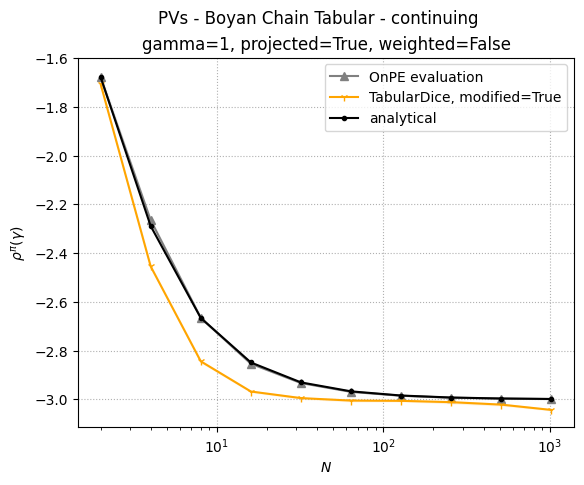

In [91]:
plot_continuing(pv_sdc="pv", errors=False, weighted=False)

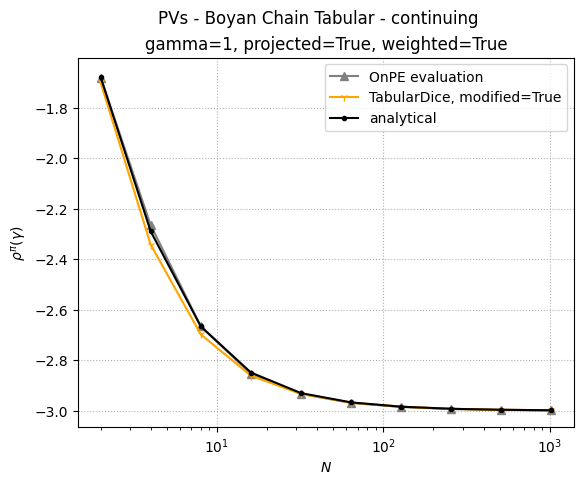

In [92]:
plot_continuing(pv_sdc="pv", errors=False, weighted=True)

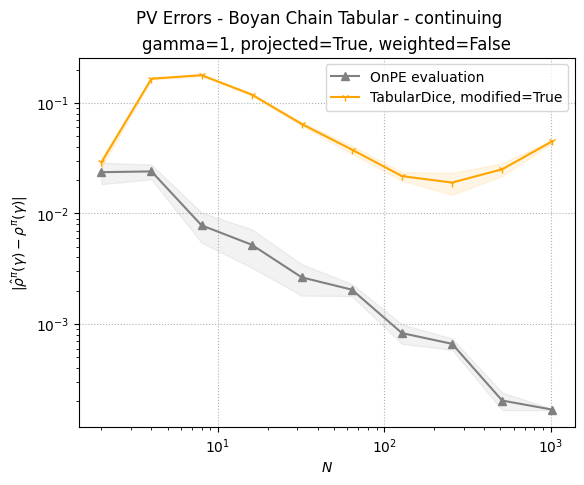

In [93]:
plot_continuing(pv_sdc="pv", errors=True, weighted=False)

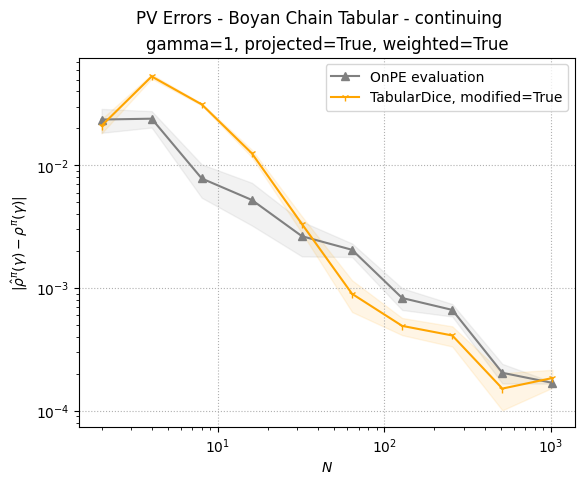

In [94]:
plot_continuing(pv_sdc="pv", errors=True, weighted=True)

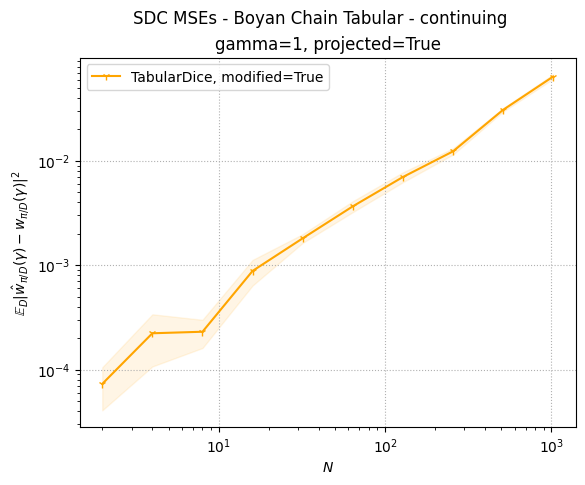

In [117]:
plot_continuing(pv_sdc="sdc")